In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from protlearn.features import aaindex1
from protlearn.preprocessing import remove_unnatural
from datetime import datetime, timedelta
from glob import glob
from scipy.optimize import curve_fit


def convert_time(t):
    try:
        x = datetime.strptime(t,'%M:%S.%f')
    except Exception:
        pass
    try:
        x = datetime.strptime(t,'%H:%M:%S')
    except Exception:
        pass
    return timedelta(hours=x.hour, minutes=x.minute, seconds=x.second, microseconds=x.microsecond).total_seconds()


def fasta_reader(file):
    '''Converts .fasta to a pandas dataframe with accession as index
    and sequence in a column 'sequence'
    '''
    fasta_df = pd.read_csv(file, sep='>', lineterminator='>', header=None)
    fasta_df[['Accession', 'Sequence']] = fasta_df[0].str.split('\n', 1, \
                                        expand=True)
    fasta_df['Accession'] = fasta_df['Accession']
    fasta_df['Sequence'] = fasta_df['Sequence'].replace('\n', '', regex=True).\
                            astype(str).str.upper().replace('U', 'C')
    total_seq = fasta_df.shape[0]
    fasta_df.drop(0, axis=1, inplace=True)
    fasta_df = fasta_df[fasta_df.Sequence != '']
    fasta_df = fasta_df[fasta_df.Sequence != 'NONE']
    final_df = fasta_df.dropna()
    remained_seq = final_df.shape[0]
    if total_seq != remained_seq:
        print("{} sequences were removed due to inconsistencies in"
                      "provided file.".format(total_seq-remained_seq))
    return final_df

### Benchmark tests on sequence lengths

#### Sample different sequence lengths

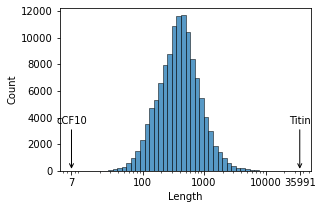

In [2]:
seq = fasta_reader('dbs.fasta')
seq['Length'] = seq.Sequence.apply(lambda x: len(x))


f, ax = plt.subplots(figsize=(4.5, 3))
# sns.despine(f)

sns.histplot(seq, x="Length", bins=50, linewidth=.5, log_scale=True)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([7, 100, 1000, 10000, 35991])

# Sex pheromone cCF10 (P20104)
ax.annotate('cCF10',
            xy=(7, 1),
            xycoords='data',
            xytext=(0, 50),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='black'),
            ha='center',
            va='center')

# human titin (Q8WZ42-12)
ax.annotate('Titin',
            xy=(35991, 1),
            xycoords='data',
            xytext=(0, 50),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='black'),
            ha='center',
            va='center')

plt.savefig('../../fig/length_distribution.pdf')

In [3]:
length = [7,25,100,500,1000,6306,26926,35991]

s = pd.concat([seq[(seq.Length==i)] for i in length])
s.Length.value_counts()

500      146
100      115
1000      19
25        10
7          2
35991      1
6306       1
26926      1
Name: Length, dtype: int64

[Text(0.5, 0, 'Total lengths of protein pairs')]

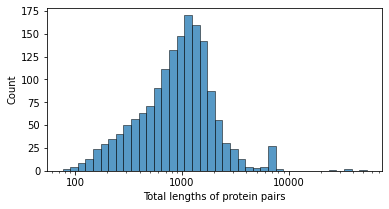

In [4]:
dbs = pd.read_pickle('dbs.pkl.gz')
dbs['ProteinA'] = dbs.Pairs.str.split('_').apply(lambda x: x[0])
dbs['ProteinB'] = dbs.Pairs.str.split('_').apply(lambda x: x[1])
a = pd.merge(dbs, s.rename(columns={'Accession':'ProteinA'}), on='ProteinA')
b = pd.merge(dbs, s.rename(columns={'Accession':'ProteinB'}), on='ProteinB')
h = pd.concat([a,b])
h = h.drop_duplicates('Pairs').drop(['Sequence','Length'], axis=1).reset_index(drop=True)
h = pd.merge(pd.merge(h, seq.rename(columns={'Accession':'ProteinA'}), on='ProteinA'),\
             seq.rename(columns={'Accession':'ProteinB'}), on='ProteinB')
h['Length'] = h.Length_x + h.Length_y
h = h.drop_duplicates('Length')
# h[['ProteinA','ProteinB']].to_csv('pairs.tsv', sep='\t', header=None, index=None)


f, ax = plt.subplots(figsize=(6, 3))
# sns.despine(f)

sns.histplot(h, x="Length", linewidth=.5, log_scale=True)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([100, 1000, 10000])
ax.set(xlabel='Total lengths of protein pairs')

#### Wall time for Scallion

````
mkdir walltime_rf; cd walltime_rf
split -l 1 ../pairs.tsv --additional-suffix=.tsv

for i in x*.tsv; do \
    echo ${i}
    /usr/bin/time -f '%E' python ../../../script/rf.py -a ../dbs.fasta -p ${i} -c ../../../clf/final_clfs.pickle
done 2>&1 | tee rf_length_1.txt

for i in *.tsv; do \
    echo ${i}
    /usr/bin/time -f '%E' python ../../../script/rf.py -a ../dbs.fasta -p ${i} -c ../../../clf/final_clfs.pickle
done 2>&1 | tee rf_length_2.txt

for i in *.tsv; do \
    echo ${i}
    /usr/bin/time -f '%E' python ../../../script/rf.py -a ../dbs.fasta -p ${i} -c ../../../clf/final_clfs.pickle
done 2>&1 | tee rf_length_3.txt


# combine results
cd ..
for i in 1 2 3; do \
    paste \
    <(awk '$1~/x/ {print "cat walltime_rf/" $1}' walltime_rf/rf_length_${i}.txt | sh) \
    <(awk -v n=${i} '$1~/:/ {print $1 "\t" n}' walltime_rf/rf_length_${i}.txt); 
done | sed 's/\t/_/' > walltime_rf_length.txt
````

#### Wall time for D-SCRIPT

```
mkdir -p walltime_dscript_1; cd walltime_dscript_1
split -l 1 ../pairs.tsv --additional-suffix=.tsv
for i in x*.tsv; do \
    echo ${i}
    /usr/bin/time -f '%E' dscript predict --pairs ${i} --model ~/compartment/src/dscript/dscript-data/models/human_v1.sav --seqs ../dbs.fasta -o ${i%.*}.out
done 2>&1 | tee dscript_length_1.txt

cd ..
mkdir -p walltime_dscript_2; cd walltime_dscript_2
split -l 1 ../pairs.tsv --additional-suffix=.tsv
for i in x*.tsv; do \
    echo ${i}
    /usr/bin/time -f '%E' dscript predict --pairs ${i} --model ~/compartment/src/dscript/dscript-data/models/human_v1.sav --seqs ../dbs.fasta -o ${i%.*}.out
done 2>&1 | tee dscript_length_2.txt

cd ..
mkdir -p walltime_dscript_3; cd walltime_dscript_3
split -l 1 ../pairs.tsv --additional-suffix=.tsv
for i in x*.tsv; do \
    echo ${i}
    /usr/bin/time -f '%E' dscript predict --pairs ${i} --model ~/compartment/src/dscript/dscript-data/models/human_v1.sav --seqs ../dbs.fasta -o ${i%.*}.out
done 2>&1 | tee dscript_length_3.txt


# combine results

for i in 1 2 3; do \
    paste \
    <(awk '$1~/x/ {print "cat walltime_rf/" $1}' walltime_rf/rf_length_${i}.txt | sh) \
    <(awk -v n=${i} '$1~/:/ {print $1 "\t" n}' walltime_rf/rf_length_${i}.txt); 
done | sed 's/\t/_/' > walltime_rf_length.txt

for i in 1 2 3; do \
    paste \
    <(awk -v n=${i} '$1~/x/ {print "cat walltime_dscript_" n "/" $1}' walltime_dscript_${i}/dscript_length_${i}.txt | sh) \
    <(sed 's/s]/\n/' walltime_dscript_${i}/dscript_length_${i}.txt | awk -v n=${i} '$1~/:/ {print $1 "\t" n}')
done | sed 's/\t/_/' > walltime_dscript_length.txt
```

#### Parse and plot wall time

In [5]:
df = []
for i in glob('walltime_*_length.txt'):
    d = pd.read_csv(i, sep='\t', header=None)
    d.columns = ['Pairs','Wall time (s)', 'Replicate']
    d['Wall time (s)'] = d['Wall time (s)'].apply(convert_time)
#     d = pd.DataFrame(d.groupby('Pairs')['Wall time (s)'].apply(np.mean)).reset_index()
    d['Tool'] = i
    df.append(d)
    
df = pd.concat(df)
df['Tool'] = df.Tool.str.replace('walltime_rf_length.txt','Scallion', regex=True)
df['Tool'] = df.Tool.str.replace('walltime_dscript_length.txt','D-SCRIPT', regex=True)
df = pd.merge(h[['Pairs','Length']], df, on='Pairs')

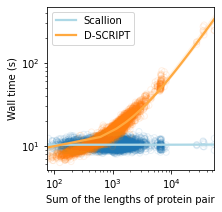

In [6]:
f, ax = plt.subplots(figsize=(3, 3))
ax.set(xscale="log", yscale="log")
sns.regplot(x='Length', y='Wall time (s)', data=df[df.Tool=='Scallion'], ax=ax, line_kws={'color':'#ADD8E6'}, scatter_kws={'facecolors':'none','alpha': 0.1})
sns.regplot(x='Length', y='Wall time (s)', data=df[df.Tool=='D-SCRIPT'], ax=ax, line_kws={'color':'#ffa940'}, scatter_kws={'facecolors':'none','alpha': 0.1})
ax.legend(labels=['Scallion', 'D-SCRIPT']) #, loc='center right', bbox_to_anchor=(1.7, 0.5), ncol=1)
plt.xlabel('Sum of the lengths of protein pair')
plt.savefig('../../fig/walltime_length.png', dpi=600, bbox_inches='tight')

### Benchmark tests on the numbers of protein pairs

#### Sample different sample sizes

In [2]:
dbs = pd.read_pickle('dbs.pkl.gz')
dbs['ProteinA'] = dbs.Pairs.str.split('_').apply(lambda x: x[0])
dbs['ProteinB'] = dbs.Pairs.str.split('_').apply(lambda x: x[1])


n = [int(i) for i in np.logspace(0,5,6)]

for i in n:
    pr = dbs.sample(n=i, random_state=12345)[['ProteinA','ProteinB']]
    pr.to_csv('pairs_' + str(i) + '.tsv', sep='\t', header=None, index=None)

#### Wall time for Scallion

````
cd walltime_rf

/usr/bin/time -f '%E' python ../../../script/rf.py
for i in ../pairs_*.tsv; do \
    echo ${i}
    /usr/bin/time -f '%E' python ../../../script/rf.py -a ../dbs.fasta -p ${i} -c ../../../clf/final_clfs.pickle
done 2>&1 | tee rf_number_1.txt

for i in ../pairs_*.tsv; do \
    echo ${i}
    /usr/bin/time -f '%E' python ../../../script/rf.py -a ../dbs.fasta -p ${i} -c ../../../clf/final_clfs.pickle
done 2>&1 | tee rf_number_2.txt

for i in ../pairs_*.tsv; do \
    echo ${i}
    /usr/bin/time -f '%E' python ../../../script/rf.py -a ../dbs.fasta -p ${i} -c ../../../clf/final_clfs.pickle
done 2>&1 | tee rf_number_3.txt

# combine results
cd ..
for i in 1 2 3; do
    paste \
<(grep tsv walltime_rf/rf_number_${i}.txt | sed 's|\.\./pairs_||;s|.tsv||') \
<(awk -v n=${i} '/^[0-9]/ {print $1 "\t" n}' walltime_rf/rf_number_${i}.txt)
done > walltime_rf_number.txt
````

#### Wall time for D-SCRIPT

```
mkdir walltime_dscript; cd walltime_dscript

for i in ../pairs_*.tsv; do \
    echo ${i}
    /usr/bin/time -f '%E' dscript predict --pairs ${i} --model ~/compartment/src/dscript/dscript-data/models/human_v1.sav --seqs ../dbs.fasta -o ${i%.*}.out
done 2>&1 | tee dscript_number_1.txt

for i in ../pairs_*.tsv; do \
    echo ${i}
    /usr/bin/time -f '%E' dscript predict --pairs ${i} --model ~/compartment/src/dscript/dscript-data/models/human_v1.sav --seqs ../dbs.fasta -o ${i%.*}.out
done 2>&1 | tee dscript_number_2.txt

for i in ../pairs_*.tsv; do \
    echo ${i}
    /usr/bin/time -f '%E' dscript predict --pairs ${i} --model ~/compartment/src/dscript/dscript-data/models/human_v1.sav --seqs ../dbs.fasta -o ${i%.*}.out
done 2>&1 | tee dscript_number_3.txt

# combine results
cd ..
for i in 1 2 3; do
    paste \
<(grep tsv walltime_dscript/dscript_number_${i}.txt | sed 's|\.\./pairs_||;s|.tsv||') \
<(sed 's/s]/\n/g' walltime_dscript/dscript_number_${i}.txt | awk -v n=${i} '$1~/:/ {print $1 "\t" n}')
done > walltime_dscript_number.txt
```

In [2]:
df = []
for i in glob('walltime_*_number.txt'):
    d = pd.read_csv(i, sep='\t', header=None)
    d.columns = ['Number of protein pairs','Wall time (s)', 'Replicate']
    d['Wall time (s)'] = d['Wall time (s)'].apply(convert_time)
#     d = pd.DataFrame(d.groupby('Pairs')['Wall time (s)'].apply(np.mean)).reset_index()
    d['Tool'] = i
    df.append(d)
    
df = pd.concat(df)
df['Tool'] = df.Tool.str.replace('walltime_rf_number.txt','Scallion', regex=True)
df['Tool'] = df.Tool.str.replace('walltime_dscript_number.txt','D-SCRIPT', regex=True)

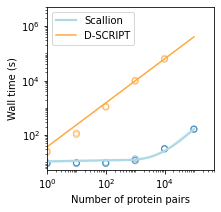

In [3]:
f, ax = plt.subplots(figsize=(3, 3))
ax.set(xscale="log", yscale="log")

sns.regplot(x='Number of protein pairs', y='Wall time (s)', data=df[df.Tool=='Scallion'], ax=ax, line_kws={'color':'#ADD8E6'}, scatter_kws={'facecolors':'none','alpha': 0.5})
plt.scatter(df[df.Tool=='D-SCRIPT']['Number of protein pairs'], df[df.Tool=='D-SCRIPT']['Wall time (s)'], edgecolors='#ffa940', facecolors="none", alpha=0.5)# palette=['#ffa940'])


def exp_func(x, a, b):
    return a * np.power(x, b)

x = np.logspace(0,5,6)
popt, pcov = curve_fit(exp_func, df[df.Tool=='D-SCRIPT']['Number of protein pairs'].to_numpy(), df[df.Tool=='D-SCRIPT']['Wall time (s)'].to_numpy())


plt.plot(x, exp_func(x, *popt), '#ffa940')
ax.legend(labels=['Scallion', 'D-SCRIPT']) #, loc='center right', bbox_to_anchor=(1.7, 0.5), ncol=1)


major = mpl.ticker.LogLocator(base = 10.0, numticks = 5)
ax.xaxis.set_major_locator(major)
ax.yaxis.set_major_locator(major)
minor = mpl.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
ax.xaxis.set_minor_locator(minor)
ax.yaxis.set_minor_locator(minor)

ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.set_xlim([None, 1000000/2])
ax.set_ylim([None, 10000000/2])

plt.savefig('../../fig/walltime_number.pdf', bbox_inches='tight')

In [4]:
df.groupby(['Number of protein pairs','Tool']).mean()['Wall time (s)']\
.apply(lambda x: str(timedelta(seconds=x)))

Number of protein pairs  Tool    
1                        D-SCRIPT     0:00:24.650000
                         Scallion     0:00:09.280000
10                       D-SCRIPT     0:01:51.956667
                         Scallion     0:00:09.440000
100                      D-SCRIPT     0:18:13.223333
                         Scallion     0:00:09.433333
1000                     D-SCRIPT     2:44:10.666667
                         Scallion     0:00:12.230000
10000                    D-SCRIPT    17:16:45.666667
                         Scallion     0:00:31.423333
100000                   Scallion     0:02:44.883333
Name: Wall time (s), dtype: object

In [5]:
df.groupby(['Number of protein pairs','Tool']).std()['Wall time (s)']\
.apply(lambda x: str(timedelta(seconds=x)))

Number of protein pairs  Tool    
1                        D-SCRIPT    0:00:01.736462
                         Scallion    0:00:00.325115
10                       D-SCRIPT    0:00:08.258113
                         Scallion    0:00:00.424382
100                      D-SCRIPT    0:00:48.807770
                         Scallion    0:00:00.490951
1000                     D-SCRIPT    0:09:03.362065
                         Scallion    0:00:01.009356
10000                    D-SCRIPT    0:47:00.985702
                         Scallion    0:00:00.672409
100000                   Scallion    0:00:03.558431
Name: Wall time (s), dtype: object

#### Wall time for E. coli proteome-wide PPI prediction

```
cd ../walltime_rf
/usr/bin/time -f '%E' python ../../../script/rf.py \
-a ../../../ref/UP000000625_83333.fasta \
-p m -c ../../../clf/final_clfs.pickle \
| awk '!seen[$1,$2]++' 2>&1 | tee rf_ecoli_1.txt
/usr/bin/time -f '%E' python ../../../script/rf.py \
-a ../../../ref/UP000000625_83333.fasta \
-p m -c ../../../clf/final_clfs.pickle \
| awk '!seen[$1,$2]++' 2>&1 | tee rf_ecoli_2.txt
/usr/bin/time -f '%E' python ../../../script/rf.py \
-a ../../../ref/UP000000625_83333.fasta \
-p m -c ../../../clf/final_clfs.pickle \
| awk '!seen[$1,$2]++' 2>&1 | tee rf_ecoli_3.txt

# combine results
grep ":" rf_ecoli_*txt | sed 's/rf_ecoli_//;s/\.txt:/\t/' > rf_ecoli.txt
```

In [6]:
e = pd.read_csv('walltime_rf/rf_ecoli.txt', sep='\t', header=None)
e.columns = ['Replicate','Wall time (s)']
e['Wall time (s)'] = e['Wall time (s)'].apply(convert_time)

str(timedelta(seconds=e['Wall time (s)'].mean())), str(timedelta(seconds=e['Wall time (s)'].std()))

('2:17:39.666667', '0:08:21.488119')